In [2]:
# Description
'''
・Drop rows with missing price values
・Create concat categorical variables and check feature importance
'''

'\n・Drop rows with missing price values\n・Create concat categorical variables and check feature importance\n'

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import optuna.integration.lightgbm as lgbm
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import itertools
import jaconv
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'optuna'

In [8]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27532 entries, 0 to 27531
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            27532 non-null  int64 
 1   region        27532 non-null  object
 2   year          27532 non-null  int64 
 3   manufacturer  27532 non-null  object
 4   condition     27532 non-null  object
 5   cylinders     27532 non-null  object
 6   fuel          26293 non-null  object
 7   odometer      27532 non-null  int64 
 8   title_status  27076 non-null  object
 9   transmission  27532 non-null  object
 10  drive         27532 non-null  object
 11  size          27532 non-null  object
 12  type          27076 non-null  object
 13  paint_color   27532 non-null  object
 14  state         24228 non-null  object
 15  price         27532 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 3.4+ MB


In [64]:
def convert(df, column):
    df[column] = df[column].str.lower()
    values = df[column].values.tolist()
    new_values = [jaconv.z2h(x, kana=False, ascii=True, digit=False) for x in values]
    df[column] = new_values
    return df

def clean_data(orig_df):
    # Create a copy
    df_cleaned = orig_df.copy()

    # Subtract 1000 from years > 2023
    df_cleaned.loc[df_cleaned['year'] > 2023, 'year'] = df_cleaned.loc[df_cleaned['year'] > 2023, 'year'] - 1000

    # Handle negative and unrealistic odometer values (treat all negative values including -1 to be outliers)
    df_cleaned.loc[(df_cleaned['odometer'] < 0) | (df_cleaned['odometer'] > 1e6), 'odometer'] = df_cleaned['odometer'].mean()

    # Make manufacturer lowercase and hankaku
    df_cleaned = convert(df_cleaned, 'manufacturer')

    # feature creation
    cat_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

    # average odometer by manufacturer
    df_cleaned['odometer_by_manufacturer'] = df_cleaned.groupby('manufacturer')['odometer'].transform('mean')

    # average odometer by state
    df_cleaned['odometer_by_state'] = df_cleaned.groupby('state')['odometer'].transform('mean')

    # average year by manufacturer
    df_cleaned['year_by_manufacturer'] = df_cleaned.groupby('manufacturer')['year'].transform('mean')

    # average odometer by year
    df_cleaned['odometer_by_year'] = df_cleaned.groupby('year')['odometer'].transform('mean')

    # concat categorical features
    df_cleaned['condition_paint_color'] = df_cleaned['condition'] + '_' + df_cleaned['paint_color']
    df_cleaned['condition_drive'] = df_cleaned['condition'] + '_' + df_cleaned['drive']
    df_cleaned['condition_manufacturer'] = df_cleaned['condition'] + '_' + df_cleaned['manufacturer']
    df_cleaned['model'] = df_cleaned['manufacturer'] + '_' + df_cleaned['cylinders'] + '_' + df_cleaned['size'] + '_' + df_cleaned['type'] + '_' + df_cleaned['drive'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['paint_color']
    df_cleaned['status'] = df_cleaned['condition'] + '_' + df_cleaned['title_status']
    
    return df_cleaned

train_ = clean_data(train)
test_ = clean_data(test)

fold 1 MAPE: 44.950352310612764


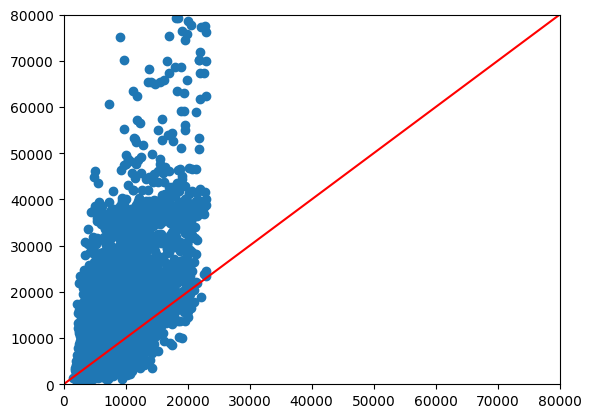

fold 2 MAPE: 44.06578886425914


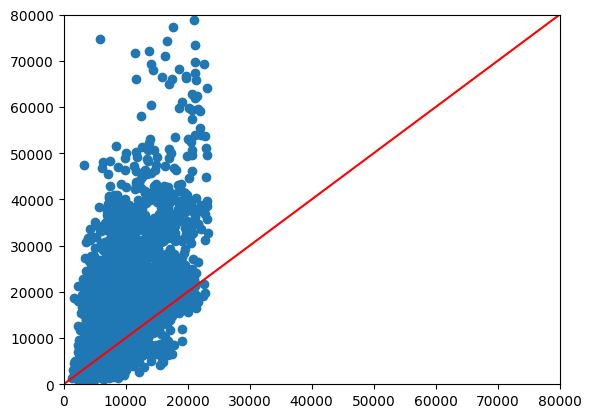

fold 3 MAPE: 45.917032442359826


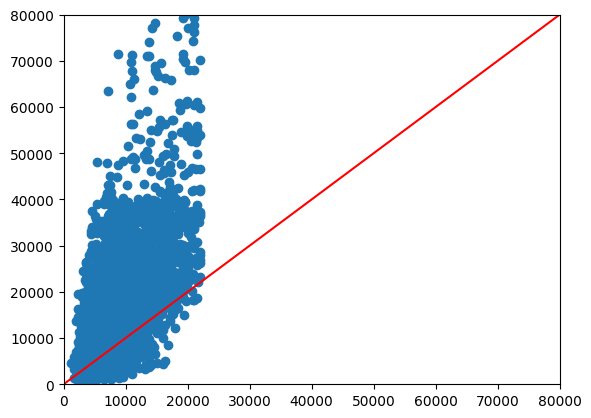

fold 4 MAPE: 45.44216227199792


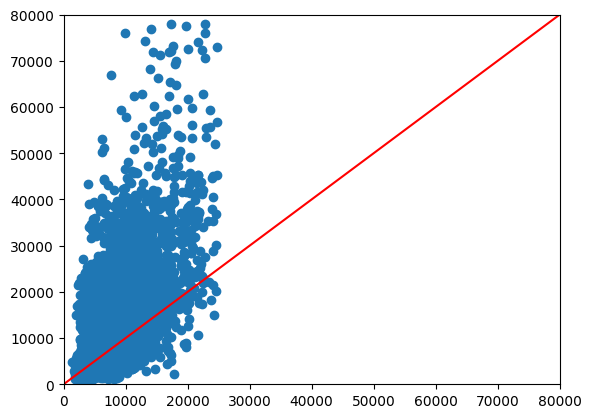

fold 5 MAPE: 44.666921151776265


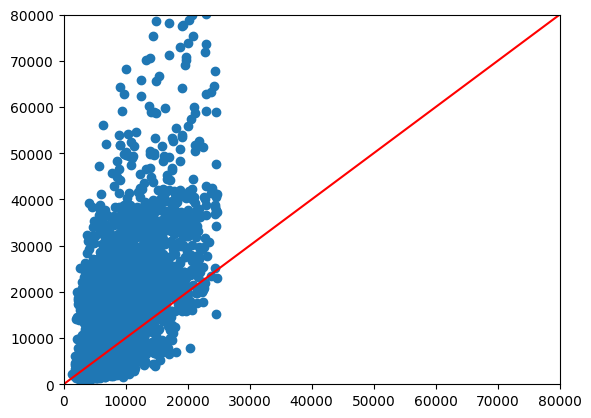

CV score: 45.008451408201175


In [65]:
# lightGBM with Target Encoding

target = train_['price']
train_for_learning = train_.drop(['id', 'price', 'year_bin'], axis=1)
test_for_eval = test_.drop(['id', 'state'], axis=1)
models, valid_scores = [], []

KFOLD = 5
kf = KFold(n_splits=KFOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(train_for_learning)):

    # split data
    X_train, X_valid = train_for_learning.iloc[train_indices], train_for_learning.iloc[valid_indices]
    y_train, y_valid = target.iloc[train_indices], target.iloc[valid_indices]

    # Target Encoding
    cat_cols = X_train.select_dtypes(include=['object']).columns
    for col in cat_cols:
        data_tmp = pd.DataFrame({col: X_train[col], 'price': y_train})
        target_mean = data_tmp.groupby(col)['price'].mean()
        X_valid[col] = X_valid[col].map(target_mean)

        tmp = X_train[col].map(target_mean)
        kf_ = KFold(n_splits=5, shuffle=True, random_state=72)
        for idx1, idx2 in kf_.split(X_train):
            target_mean = data_tmp.iloc[idx1].groupby(col)['price'].mean()
            tmp.iloc[idx2] = X_train[col].iloc[idx2].map(target_mean)
        
        X_train[col] = tmp

    # train
    train_set = lgbm.Dataset(X_train, y_train)
    valid_set = lgbm.Dataset(X_valid, y_valid)
    params = {
        "objective": "mape",
        "metrics": "mape",
        "verbosity": -1,
    }
    model = lgbm.train(
        params=params,
        train_set=train_set,
        valid_sets=valid_set,
        num_boost_round=100, 
        early_stopping_rounds=20
    )
    pred = model.predict(X_valid)
    models.append(model)

    score = 100*mean_absolute_percentage_error(y_valid, pred)
    valid_scores.append(score)
    print(f'fold {fold+1} MAPE: {score}')

    plt.scatter(pred, y_valid)
    plt.xlim(0, 80000)
    plt.ylim(0, 80000)
    plt.plot(range(80000), range(80000), color='red')
    plt.show()

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

# feature importance
importances = []
for fold, model in enumerate(models):
    importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X_train.columns, columns=[fold+1])
    importances.append(importance)

total_importance = pd.concat(importances, axis=1)
total_importance = (1e5*total_importance.sum(axis=1)/KFOLD).sort_values(ascending=False)
total_importance.to_csv('importance.csv')

In [ ]:
# submit
pred = np.array([model.predict(test_for_eval) for model in models])
pred = np.mean(pred, axis=0)

submit = pd.read_csv("data/submit_sample.csv", header=None)
submit[1] = pred
submit.to_csv("submission.csv", index=False, header=None)

In [6]:
# ensemble model (regression + classification)
KFOLD = 5
reg_target = train_['price']
clf_target = train_['price'].apply(lambda x: 1 if x >= 60000 else 0)
train_for_learning = train_.drop(['id', 'price', 'state', 'region'], axis=1)
out_price = 60000

kf = KFold(n_splits=KFOLD, shuffle=True, random_state=42)
reg_models, clf_models, valid_scores = [], [], []

for fold, (train_indices, valid_indices) in enumerate(kf.split(train_for_learning)):
    X_train, X_valid = train_for_learning.iloc[train_indices], train_for_learning.iloc[valid_indices]
    reg_y_train, reg_y_valid = reg_target.iloc[train_indices], reg_target.iloc[valid_indices]
    clf_y_train, clf_y_valid = clf_target.iloc[train_indices], clf_target.iloc[valid_indices]

    reg_train_set = lgbm.Dataset(X_train, reg_y_train)
    reg_valid_set = lgbm.Dataset(X_valid, reg_y_valid)
    clf_train_set = lgbm.Dataset(X_train, clf_y_train)
    clf_valid_set = lgbm.Dataset(X_valid, clf_y_valid)

    # regression model
    params = {
        "objective": "mape",
        "metrics": "mape",
        "verbosity": -1,
    }
    reg_model = lgbm.train(
        params=params,
        train_set=reg_train_set,
        valid_sets=reg_valid_set,
    )
    reg_pred = reg_model.predict(X_valid)
    reg_models.append(reg_model)

    # classification model
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        "verbosity": -1,
    }
    clf_model = lgbm.train(
        params=params,
        train_set=clf_train_set,
        valid_sets=clf_valid_set,
    )
    clf_pred = clf_model.predict(X_valid)
    clf_models.append(clf_model)
    score = clf_model.best_score['valid_0']['auc']
    print(f'fold {fold+1} AUC: {score}')

    pred_df = pd.DataFrame({'reg': reg_pred, 'clf': clf_pred})
    pred_df.to_csv('pred.csv')
    pred = [reg if clf < 0.5 else out_price for reg, clf in zip(reg_pred, clf_pred)]
    pred = reg_pred

    score = 100*mean_absolute_percentage_error(reg_y_valid, pred)
    valid_scores.append(score)
    print(f'fold {fold+1} MAPE: {score}')

    plt.scatter(pred, reg_y_valid)
    plt.xlim(0, 80000)
    plt.ylim(0, 80000)
    plt.plot(range(80000), range(80000), color='red')
    plt.show()

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

importances = []
for fold, model in enumerate(reg_models):
    importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X_train.columns, columns=[fold+1])
    importances.append(importance)

total_importance = pd.concat(importances, axis=1)
total_importance = (1e5*total_importance.sum(axis=1)/KFOLD).sort_values(ascending=False)
total_importance.to_csv('importance.csv')

NameError: name 'train_' is not defined